In [62]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
import time

In [2]:
df = pd.read_csv("./malware-detection/tek_data.csv")

In [3]:
#deleting columnns permanently
df = df.drop('ID', axis=1)

In [138]:
y = df['legitimate']
x = df.drop('legitimate', axis=1)

In [48]:
x=(x-x.mean())/x.std()

In [50]:
y = pd.get_dummies(y)

In [32]:
# le.fit(y)
# y = le.transform(y)

In [36]:
# y = y.reshape(y.shape[0],1)

In [140]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [52]:
x_train = x_train.transpose()
y_train = y_train.transpose()
x_test = x_test.transpose()
y_test = y_test.transpose()

In [53]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(54, 117339)
(2, 117339)
(54, 20708)
(2, 20708)


In [12]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, shape=(n_x, None))
    Y = tf.placeholder(tf.float32, shape=(n_y, None))
    
    return X, Y

In [13]:
X, Y = create_placeholders(33, 1)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(33, ?), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(1, ?), dtype=float32)


In [54]:
def initialize_parameters():
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [25, 54], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2, 12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [2, 1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [15]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
W1 = <tf.Variable 'W1:0' shape=(25, 33) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


In [21]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                                # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                                            # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [17]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(33, 1)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(2, ?), dtype=float32)


In [18]:
def compute_cost(Z3, Y):

    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)

    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [19]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(33, 1)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [132]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 10, print_cost = True):

    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            seed = seed + 1

            _ , epoch_cost = sess.run([optimizer, cost], feed_dict={X:X_train, Y:Y_train})
    
            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
                
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        
#         print (sess.run([Z3], feed_dict={X:X_train}))
        # Calculate the correct predictions
        predict_op = tf.argmax(Z3)
        tf.add_to_collection("predict_op", predict_op)

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
#         print (sess.run([predict_op], feed_dict={X:X_train}))
#         print (sess.run([predict_op], feed_dict={X:X_test}))
        pred = sess.run([predict_op], feed_dict={X:X_test})
        return pred[0]

Cost after epoch 0: 0.791024
Cost after epoch 5: 0.781017


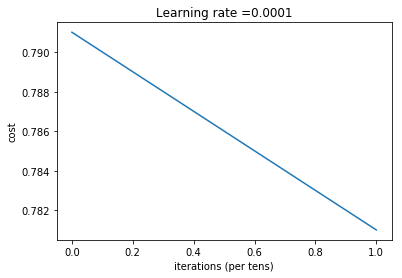

Parameters have been trained!
Train Accuracy: 0.3311346
Test Accuracy: 0.33161098


In [133]:
start_time = time.time()
pred = model(x_train, y_train, x_test, y_test)
end_time = time.time()

In [141]:
print ("sklearn neural network Accuracy: " + str(metrics.accuracy_score(pred,y_test)))
print ("total running time:" + str(end_time - start_time))
print ("precision: " + str(metrics.precision_score(y_test, pred, average='macro')))
print ("recall:" + str(metrics.recall_score(y_test, pred, average='macro')))
print ("confusion matrix:" + str(metrics.confusion_matrix(y_test, pred)))

sklearn neural network Accuracy: 0.3316109716051767
total running time:4.621078014373779
precision: 0.474529011676899
recall:0.4895241436477124
confusion matrix:[[ 1295 13148]
 [  693  5572]]
